In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('streamlit_app\data\superstore.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         9994 non-null   int64  
 1   order_id       9994 non-null   object 
 2   order_date     9994 non-null   object 
 3   ship_date      9994 non-null   object 
 4   ship_mode      9994 non-null   object 
 5   customer_id    9994 non-null   object 
 6   customer_name  9994 non-null   object 
 7   segment        9994 non-null   object 
 8   country        9994 non-null   object 
 9   city           9994 non-null   object 
 10  state          9994 non-null   object 
 11  postal_code    9994 non-null   int64  
 12  region         9994 non-null   object 
 13  product_id     9994 non-null   object 
 14  category       9994 non-null   object 
 15  subcategory    9994 non-null   object 
 16  product_name   9994 non-null   object 
 17  sales          9994 non-null   float64
 18  quantity

In [3]:
df['customer_name'].nunique()

793

In [4]:
best_customer = pd.pivot_table(
    data=df,
    index='customer_name',
    aggfunc={
        'sales': 'sum'
    } ).reset_index()


In [5]:
best_customer = best_customer.sort_values(by=['sales'], ascending=False).head(10)
# best_customer.reset_index(inplace=True)
best_customer['sales'] = best_customer['sales'].round(2)

In [6]:
best_customer

,customer_name,sales
686,Sean Miller,25043.05
730,Tamara Chand,19052.22
622,Raymond Buch,15117.34
757,Tom Ashbrook,14595.62
6,Adrian Barton,14473.57
441,Ken Lonsdale,14175.23
671,Sanjit Chand,14142.33
334,Hunter Lopez,12873.30
672,Sanjit Engle,12209.44
156,Christopher Conant,12129.07


In [7]:
group_cat_customer = pd.pivot_table(
    data=df,
    index=['customer_name', 'category'],
    aggfunc={
        'sales': 'sum'
    }
).reset_index()

In [8]:
group_cat_customer

,customer_name,category,sales
0,Aaron Bergman,Furniture,390.672
1,Aaron Bergman,Office Supplies,273.504
2,Aaron Bergman,Technology,221.980
3,Aaron Hawkins,Furniture,365.906
4,Aaron Hawkins,Office Supplies,675.864
...,...,...,...
2177,Zuschuss Carroll,Office Supplies,1819.645
2178,Zuschuss Carroll,Technology,2306.372
2179,Zuschuss Donatelli,Furniture,87.840
2180,Zuschuss Donatelli,Office Supplies,108.704


In [9]:
merged_df = pd.merge(best_customer, group_cat_customer, on='customer_name', how='left')
merged_df.head()

,customer_name,sales_x,category,sales_y
0,Sean Miller,25043.05,Furniture,679.570
1,Sean Miller,25043.05,Office Supplies,881.972
2,Sean Miller,25043.05,Technology,23481.508
3,Tamara Chand,19052.22,Office Supplies,1054.268
4,Tamara Chand,19052.22,Technology,17997.950


In [10]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])
df['order_year'] = df['order_date'].dt.year

In [11]:
# Calculating Frequency
recency_df = df.groupby('customer_name', as_index=False)['order_date'].max()
recent_date = recency_df['order_date'].max()
recency_df['Recency'] = recency_df['order_date'].apply(
    lambda x: (recent_date - x).days)
recency_df.rename(columns={'order_date':'Last Purchase Date'}, inplace=True)

# Calculating Frequency
frequency_df = df.groupby('customer_name', as_index=False)['order_date'].count()
frequency_df.rename(columns={'order_date':'Frequency'}, inplace=True)

# Calculating monetary
monetary_df = df.groupby('customer_name', as_index=False)['sales'].sum()
monetary_df.rename(columns={'sales':'Monetary'}, inplace=True)

# Merging all three df in one df
rfm_df = recency_df.merge(frequency_df, on='customer_name')
rfm_df = rfm_df.merge(monetary_df, on='customer_name')
rfm_df['Monetary'] = rfm_df['Monetary'].round(2)
rfm_df.drop(['Last Purchase Date'], axis=1, inplace=True)

rank_df = rfm_df.copy() # We make copy of rfm_df because we will need RFM features later

# Normalizing the rank of the customers
rank_df['r_rank'] = rank_df['Recency'].rank(ascending=False)
rank_df['f_rank'] = rank_df['Frequency'].rank(ascending=False)
rank_df['m_rank'] = rank_df['Monetary'].rank(ascending=False)

rank_df['r_rank_norm'] = (rank_df['r_rank'] / rank_df['r_rank'].max()) * 100
rank_df['f_rank_norm'] = (rank_df['f_rank'] / rank_df['f_rank'].max()) * 100
rank_df['m_rank_norm'] = (rank_df['m_rank'] / rank_df['m_rank'].max()) * 100

rank_df.drop(['r_rank','f_rank','m_rank'], axis=1, inplace=True)

# Calculating RFM scores
rank_df['rfm_score'] = (0.15*rank_df['r_rank_norm']) + (0.28*rank_df['f_rank_norm']) + (0.57*rank_df['m_rank_norm'])
rank_df = rank_df[['customer_name','rfm_score']]
rank_df['rfm_score'] = round(rank_df['rfm_score']*0.05, 2)

# Masking all customers rfm scores by rating conditions to set customer segments easily
top_customer_mask = (rank_df['rfm_score'] >= 4.5)
high_value_mask = ((rank_df['rfm_score']<4.5) & (rank_df['rfm_score']>=4))
medium_value_mask = ((rank_df['rfm_score']<4) & (rank_df['rfm_score']>=3))
low_value_mask = ((rank_df['rfm_score']<3) & (rank_df['rfm_score']>=1.6))
lost_mask = (rank_df['rfm_score'] < 1.6)

rank_df.loc[top_customer_mask, 'Customer Segment'] = 'Top Customer'
rank_df.loc[high_value_mask, 'Customer Segment'] = 'High Value Customer'
rank_df.loc[medium_value_mask, 'Customer Segment'] = 'Medium Value Customer'
rank_df.loc[low_value_mask, 'Customer Segment'] = 'Low Value Customer'
rank_df.loc[lost_mask, 'Customer Segment'] = 'Lost Customer'

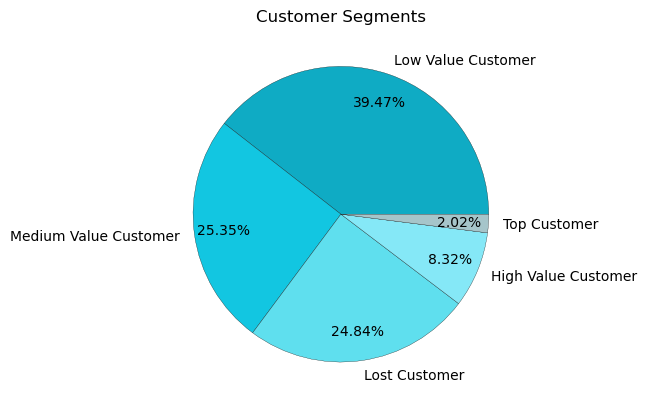

In [12]:
from matplotlib import pyplot as plt
# Visualization of customer segments
colors = ['#0FABC4','#12C6E1','#5FDFEE','#85E8F7','#A6C5CA']
plt.pie(rank_df['Customer Segment'].value_counts(), labels=rank_df['Customer Segment'].value_counts().index,
       autopct='%.2f%%', pctdistance=0.8, labeldistance=1.1, colors=colors,
       shadow=False, wedgeprops={'edgecolor':'k','linewidth':0.2})
plt.title('Customer Segments')
plt.show()

In [13]:
rank_df

,customer_name,rfm_score,Customer Segment
0,Aaron Bergman,3.63,Medium Value Customer
1,Aaron Hawkins,3.16,Medium Value Customer
2,Aaron Smayling,2.21,Low Value Customer
3,Adam Bellavance,0.86,Lost Customer
4,Adam Hart,1.60,Low Value Customer
...,...,...,...
788,Xylona Preis,1.87,Low Value Customer
789,Yana Sorensen,1.59,Lost Customer
790,Yoseph Carroll,2.15,Low Value Customer
791,Zuschuss Carroll,0.60,Lost Customer


In [14]:
group_rfm_customer = pd.pivot_table(
    data=rank_df,
    index='Customer Segment',
    values='rfm_score',
    aggfunc='mean'
).reset_index()

In [15]:
group_rfm_customer['rfm_score'] = group_rfm_customer['rfm_score'].round(2)
group_rfm_customer

,Customer Segment,rfm_score
0,High Value Customer,4.22
1,Lost Customer,1.10
2,Low Value Customer,2.28
3,Medium Value Customer,3.50
4,Top Customer,4.62


In [16]:
merged_rfm_cust = pd.merge(rank_df, group_rfm_customer, on='Customer Segment', how='left')
merged_rfm_cust.head()

,customer_name,rfm_score_x,Customer Segment,rfm_score_y
0,Aaron Bergman,3.63,Medium Value Customer,3.50
1,Aaron Hawkins,3.16,Medium Value Customer,3.50
2,Aaron Smayling,2.21,Low Value Customer,2.28
3,Adam Bellavance,0.86,Lost Customer,1.10
4,Adam Hart,1.60,Low Value Customer,2.28


In [17]:
lost_customer_df = merged_rfm_cust.loc[merged_rfm_cust['Customer Segment'] == 'Lost Customer']
lost_customer_df_detail = pd.merge(lost_customer_df, df, on='customer_name', how='left')
lost_customer_df_detail.head()

,customer_name,rfm_score_x,Customer Segment,rfm_score_y,row_id,order_id,order_date,ship_date,ship_mode,customer_id,...,region,product_id,category,subcategory,product_name,sales,quantity,discount,profit,order_year
0,Adam Bellavance,0.86,Lost Customer,1.1,350,CA-2016-129714,2016-09-01,2016-09-03,First Class,AB-10060,...,East,TEC-AC-10000290,Technology,Accessories,Sabrent 4-Port USB 2.0 Hub,6.790,1,0.0,2.3086,2016
1,Adam Bellavance,0.86,Lost Customer,1.1,351,CA-2016-129714,2016-09-01,2016-09-03,First Class,AB-10060,...,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,24.560,2,0.0,11.5432,2016
2,Adam Bellavance,0.86,Lost Customer,1.1,352,CA-2016-129714,2016-09-01,2016-09-03,First Class,AB-10060,...,East,OFF-BI-10002160,Office Supplies,Binders,Acco Hanging Data Binders,3.048,1,0.2,1.0668,2016
3,Adam Bellavance,0.86,Lost Customer,1.1,353,CA-2016-129714,2016-09-01,2016-09-03,First Class,AB-10060,...,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,49.120,4,0.0,23.0864,2016
4,Adam Bellavance,0.86,Lost Customer,1.1,354,CA-2016-129714,2016-09-01,2016-09-03,First Class,AB-10060,...,East,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,4355.168,4,0.2,1415.4296,2016


In [18]:
lost_customer_df_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3761 entries, 0 to 3760
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_name     3761 non-null   object        
 1   rfm_score_x       3761 non-null   float64       
 2   Customer Segment  3761 non-null   object        
 3   rfm_score_y       3761 non-null   float64       
 4   row_id            3761 non-null   int64         
 5   order_id          3761 non-null   object        
 6   order_date        3761 non-null   datetime64[ns]
 7   ship_date         3761 non-null   datetime64[ns]
 8   ship_mode         3761 non-null   object        
 9   customer_id       3761 non-null   object        
 10  segment           3761 non-null   object        
 11  country           3761 non-null   object        
 12  city              3761 non-null   object        
 13  state             3761 non-null   object        
 14  postal_code       3761 n

In [19]:
lost_customer_df_detail = lost_customer_df_detail.loc[:, ['customer_name', 'country', 'city', 'state', 'postal_code', 'region', 'category', 'subcategory']].reset_index(drop=True)
lost_customer_df_detail.head()

,customer_name,country,city,state,postal_code,region,category,subcategory
0,Adam Bellavance,United States,New York City,New York,10009,East,Technology,Accessories
1,Adam Bellavance,United States,New York City,New York,10009,East,Office Supplies,Paper
2,Adam Bellavance,United States,New York City,New York,10009,East,Office Supplies,Binders
3,Adam Bellavance,United States,New York City,New York,10009,East,Office Supplies,Paper
4,Adam Bellavance,United States,New York City,New York,10009,East,Office Supplies,Binders


In [20]:
top_prod = pd.pivot_table(
    data=df,
    index='subcategory',
    aggfunc={
        'sales': 'sum',
        'product_id': pd.Series.nunique
    } ).reset_index()

In [30]:
categories = ['Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases',
                'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings',
                'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies',
                'Tables']

fixed_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999', '#000000', '#00ff7f', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

color_discrete_map = {category: color for category, color in zip(categories, fixed_colors)}

In [28]:
categories[1]

'Appliances'